In [1]:
#import libraries and packages

from gurobipy import *
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get current working directory 
path = os.getcwd()

In [3]:
# import tracts, pods, and distances

with open(path+'/tracts.csv', 'r', encoding='utf-8-sig') as f: 
    tracts = np.genfromtxt(f, dtype=float, delimiter=',') # residential areas
    
with open(path+'/pods.csv', 'r', encoding='utf-8-sig') as f: 
    pods = np.genfromtxt(f, dtype=float, delimiter=',') # sites
    
with open(path+'/dists.csv', 'r', encoding='utf-8-sig') as f: 
    dists = np.genfromtxt(f, dtype=float, delimiter=',')

In [4]:
# capacity = np.sum(pods[:,2]) #total capacity of all pods
popTotal = np.sum(tracts[:,2]) # total population in Allegheny County

residents = tracts[:,2] # population of tracts
capacity = pods[:,2] # capacity of pods

In [5]:
# indices for tracts and pods
p = len(tracts) #census tracts
q = len(pods) #pods

n_tracts = range(p) # number of tracts
n_pods = range(q) # number of pods

P = 20 #number of pods that can be built (subject to change)
I = .1 #proportion of population at each tract to be served (subject to change)

In [6]:
# setting up model object

m = Model("Assignments")

Using license file /Users/prastha/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-29


In [7]:
# setting up the decision variables

# where to build the pods
x = m.addVars(n_pods, vtype=GRB.BINARY) #1 if pod j is built

# where to assign which tracts to which pods
y = m.addVars(n_tracts, n_pods, vtype=GRB.BINARY) #1 if area i assigned to pod j

In [8]:
# Objective Function

objFn = LinExpr()

objFn += sum(sum(dists[i,j] * y[i,j] * (residents[i]) for i in n_tracts) for j in n_pods)
#
m.setObjective(objFn)

m.modelSense = GRB.MINIMIZE

In [9]:
# Constraints

# number of total sites that we could build
m.addConstr(sum(x[j] for j in n_pods) <= P) 

# capacity constraints
for j in n_pods:
    m.addConstr(sum(residents[i] * y[i,j] for i in n_tracts) <= 30 * 2 * capacity[j] * x[j]) 

# a residential can have at most one shelter
for i in n_tracts:
    m.addConstr(sum(y[i,j] for j in n_pods) == 1) 

# all residential areas must be met
m.addConstr(sum(sum(y[i,j] for j in n_pods) for i in n_tracts) >= len(residents)) 

# a tract can only be assigned to a pod that as been built
for i in n_tracts:
    for j in n_pods:
        m.addConstr(x[j] - y[i,j] >= 0)

In [10]:
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 19345 rows, 18941 columns and 94329 nonzeros
Model fingerprint: 0xf1fe4f08
Variable types: 0 continuous, 18941 integer (18941 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [6e-01, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.19s
Presolved: 19344 rows, 18941 columns, 75435 nonzeros
Variable types: 0 continuous, 18941 integer (18941 binary)
Found heuristic solution: objective 8689091.0254

Root relaxation: objective 2.706997e+06, 1596 iterations, 0.22 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2706997.46    0  102 8689091.03 2706997.46  68.8%     -    0s
H    0     0                    28

In [11]:
print(m.objVal)

2711491.157015197


In [12]:
# New Optimization Model
# Minimax Problem

# new optimization model
m1 = Model("MiniMax")

# pods
x1 = m1.addVars(n_pods, vtype = GRB.BINARY) # same as x_j (whether a pod is built on site j)

# tracts
y1 = m1.addVars(n_tracts, n_pods, vtype=GRB.BINARY) # same as y_ij (whether a residential area
                                                    # i is assigned to site j)

In [13]:
# max distance
maxDistance = m1.addVars(1,1, lb = 0.0) # a new decision variable to pick the maximum distance
                                        # between the tract (residential area) to pods

m1.setObjective(maxDistance[0,0])
m1.modelSense = GRB.MINIMIZE

In [14]:
# Constraints

# number of total sites that we could build
m1.addConstr(sum(x1[j] for j in n_pods) <= P) 

# capacity constraints
for j in n_pods:
    m1.addConstr(sum(residents[i] * y1[i,j] for i in n_tracts) <= 30 * 2 * capacity[j] * x1[j]) 

# a residential can have at most one shelter
for i in n_tracts:
    m1.addConstr(sum(y1[i,j] for j in n_pods) == 1) 

# all residential areas must be met
m1.addConstr(sum(sum(y1[i,j] for j in n_pods) for i in n_tracts) >= len(residents)) 

# a tract can only be assigned to a pod that as been built
for i in n_tracts:
    for j in n_pods:
        m1.addConstr(x1[j] - y1[i,j] >= 0)

# the distance to shelter must be less than or equal to the maximum distance
for j in n_pods:
    for i in n_tracts:
        m1.addConstr(dists[i,j] * y1[i,j] <= maxDistance[0,0])


In [15]:
m1.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 38239 rows, 18942 columns and 132117 nonzeros
Model fingerprint: 0x472afc4b
Variable types: 1 continuous, 18941 integer (18941 binary)
Coefficient statistics:
  Matrix range     [2e-02, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 549 rows and 0 columns
Presolve time: 0.43s
Presolved: 37690 rows, 18942 columns, 112172 nonzeros
Variable types: 1 continuous, 18941 integer (18941 binary)
Found heuristic solution: objective 23.0760613

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14877    2.2071251e+00   0.000000e+00   1.380942e+01      5s
   15110    2.1152501e+00   0.000000e+00   0.000000e+00      5s
   15110    2.1152501e+00 

 320705 74747 infeasible  339         4.86069    4.82523  0.73%   6.1   95s
 364246 83360    4.83361  338   19    4.86069    4.82523  0.73%   5.9  100s
 410453 91796    4.82523  318   14    4.86069    4.82523  0.73%   5.9  105s
 455239 100496    4.82523  324   14    4.86069    4.82523  0.73%   5.9  110s
 490006 107301 infeasible  323         4.86069    4.82523  0.73%   5.9  115s
 534978 116027    4.82523  297   12    4.86069    4.82523  0.73%   5.9  120s
 573468 122253    4.82523  290   12    4.86069    4.82523  0.73%   5.9  125s
 611667 128895 infeasible  322         4.86069    4.82523  0.73%   5.9  130s
 640946 133566 infeasible  330         4.86069    4.82523  0.73%   5.9  135s
 675040 140547    4.82523  331   16    4.86069    4.82523  0.73%   5.9  140s
 714180 146338    4.84649  301   17    4.86069    4.82523  0.73%   6.0  145s
 750395 153417    4.83186  331   14    4.86069    4.82523  0.73%   5.9  150s
 791095 159098    4.82523  328   14    4.86069    4.82523  0.73%   5.9  155s
 8

In [16]:
print(m1.objVal)

4.825226622


## Visualization of Tracts  Assignment to Pods

In [31]:
DistanceToSite = [] # list of all the distances between the tracts and their assigned pods
residenceSitePair = [] # tracts and pods pair

for i in n_tracts:
    for j in n_pods:
        if y[i,j].x == 1:
            residenceSitePair.append((i,j))

for a, b in residenceSitePair:
    # distance = abs(tracts[a][0] - pods[b][0]) + abs(tracts[a][1] - pods[b][1]) # grid distance
    distance = np.sqrt((tracts[a][0] - pods[b][0]) ** 2 + abs(tracts[a][1] - pods[b][1]) ** 2) # eucledian distance
    DistanceToSite.append(distance)

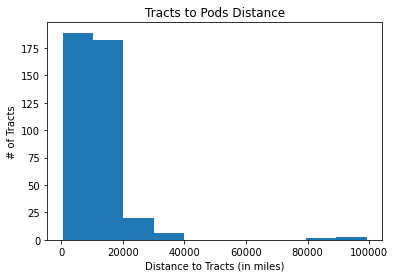

In [32]:
# plotting histogram

plt.hist(DistanceToSite)

plt.title("Tracts to Pods Distance")
plt.xlabel("Distance to Tracts (in miles)")
plt.ylabel("# of Tracts")

plt.show()

In [36]:
# same setup as before but for for the minimax model this time

DistanceToSite1 = []
residenceSitePair1 = []

for i in n_tracts:
    for j in n_pods:
        if y1[i,j].x == 1:
            residenceSitePair1.append((i,j))

for a, b in residenceSitePair1:
    # distance1 = abs(tracts[a][0] - pods[b][0]) + abs(tracts[a][1] - pods[b][1]) # grid distance
    distance1 = np.sqrt((tracts[a][0] - pods[b][0]) ** 2 + abs(tracts[a][1] - pods[b][1]) ** 2) # eucledian distance
    DistanceToSite1.append(distance1)

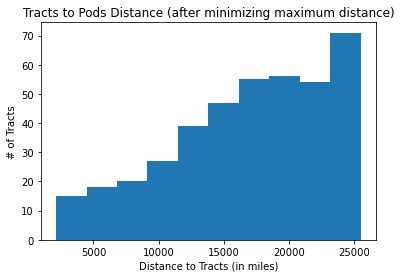

In [37]:
# plotting histogram

plt.hist(DistanceToSite1)

plt.title("Tracts to Pods Distance (after minimizing maximum distance)")
plt.xlabel("Distance to Tracts (in miles)")
plt.ylabel("# of Tracts")

plt.show()